In [1]:
# IMPORTS
import pandas as pd
import numpy as np
import os 

import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.pyplot import figure

from scipy.stats import ttest_ind
import json

from tqdm import tqdm

## Load Data 

In [47]:
DATASET_DIRECTORY = 'dataset/MovieSummaries/'

# Load actors df 
character_columns = ['Wikipedia_ID','Freebase_ID', 'release_date', 'movie_name','date_of_birth', 'sex' , 'height',
                     'ethnicity', 'actor_name', 'age_at_release', 'character2actor_map_ID', 'character_ID', 'actor_ID']
actors_df = pd.read_csv(DATASET_DIRECTORY + 'character.metadata.tsv', sep='\t',  header=None,names=character_columns,skiprows=1)

# Load movies df
movie_columns = ['Wikipedia_ID','Freebase_ID','name','release_date', 'box_office_revenue', 'runtime', 'languages', 'countries', 'genres' ]
movies_df = pd.read_csv(DATASET_DIRECTORY + 'movie.metadata.tsv', sep='\t',  header=None,names=movie_columns,skiprows=1)

# Load plots summaries
with open(DATASET_DIRECTORY + 'plot_summaries.txt' ) as f:
    plot_summaries = f.readlines()

## clean data

In [48]:
# remove roles without movie release dates, actor' sex or actors age at release 
actors_df = actors_df[~actors_df['release_date'].isna()]
actors_df = actors_df[~actors_df.sex.isna()]
actors_df = actors_df[~actors_df.age_at_release.isna()]

# remove movies with no release date and weird entries such as movies released before the 1800 hundreds
movies_df = movies_df[movies_df.release_date >= '1800']
movies_df = movies_df[~movies_df.release_date.isna()]

# format the date to be in a datetime format and be in years
actors_df.release_date =  actors_df.release_date.astype('datetime64[ns]').dt.year
movies_df.release_date = movies_df.release_date.astype('datetime64[ns]').dt.year

In [49]:
actors_start_2013 = actors_df[ actors_df.release_date >= 2013]

In [50]:
for x in range(2010, 2017):
    year_nb_movies = movies_df[ movies_df['release_date'] == x].shape[0]
    print(f"year {x}: {year_nb_movies} movies")

year 2010: 2022 movies
year 2011: 1824 movies
year 2012: 1194 movies
year 2013: 164 movies
year 2014: 17 movies
year 2015: 4 movies
year 2016: 3 movies


## Clean / Process Data

In [54]:
# convert genres to a list of genres for each row
movies_df['genres'] = [ [ v for k, v in  json.loads(dico).items() ] for dico in movies_df.genres.values]

In [56]:
movies_df = movies_df[ movies_df.release_date >= 2013]

In [57]:
def flatten(l):
    """
    method to flatten a list of lists to just a list 
    """
    return [item for sublist in l for item in sublist]


# compute popularity of each genre and sort them in descending order 
genres = flatten(movies_df['genres'].values)
all_genres = set(genres)
unique, counts = np.unique(genres, return_counts=True)
genres_value_counts = sorted(zip(unique, counts), key=lambda t: t[1], reverse=True)

top_genres, nb_appearances = list(map(list, zip(*genres_value_counts)))

In [58]:
movies_df.shape
# present.shape

(188, 9)

In [153]:
# select the number of top genres to analyse keeping only genres that appear more than
# MIN_NUMBER_OF_APPEARANCES times

MIN_NUMBER_OF_APPEARANCES = 16#5000
nb_genres = ( np.array(nb_appearances) >= MIN_NUMBER_OF_APPEARANCES ).sum()
selected_genres = set(top_genres[:nb_genres])

# for each movie we create nb_genres new columns who contain 1 , 0 ( True / False) values
# depending if the genre of the column appears in the movie genres field
# these new columns are useful for later sex representations by movie genres
present = np.zeros((movies_df.shape[0], len(selected_genres)))

for idx, row in movies_df.reset_index().iterrows():

    movie_genres = set(row.genres)
    for genre_idx, genre in enumerate(selected_genres):
        present[idx, genre_idx] = int(genre in movie_genres)

for idx, genre in enumerate(selected_genres):    
        movies_df[genre] = present[:, idx]


/tmp/ipykernel_89094/1173752777.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_df[genre] = present[:, idx]


In [154]:
# merge movies and actors dataframe to study gender representation in different movie genres
to_drop = ['Wikipedia_ID', 'release_date']
actors_movies_df = actors_df.merge(movies_df.drop(columns=to_drop), how='inner', on='Freebase_ID')

## Initial Analyses

In [155]:
# Interested in the number of movies and number of roles
# as well as the number of features per data point
print(f"movies: ( # movies, # features) : {movies_df.shape}")
print(f"actors: ( # actors, # features) : {actors_df.shape}")

movies: ( # movies, # features) : (188, 46)
actors: ( # actors, # features) : (290769, 13)


In [156]:
# It's important to check how much data is missing 
print("Number of missing features for movies")
print(movies_df[movie_columns].isna().sum())
print()
print("Number of missing features for actors")
print(actors_df.isna().sum())

Number of missing features for movies
Wikipedia_ID            0
Freebase_ID             0
name                    0
release_date            0
box_office_revenue    188
runtime               166
languages               0
countries               0
genres                  0
dtype: int64

Number of missing features for actors
Wikipedia_ID                   0
Freebase_ID                    0
release_date                   0
movie_name                157391
date_of_birth                  0
sex                            0
height                    151131
ethnicity                 197464
actor_name                    12
age_at_release                 0
character2actor_map_ID         0
character_ID              157388
actor_ID                       0
dtype: int64


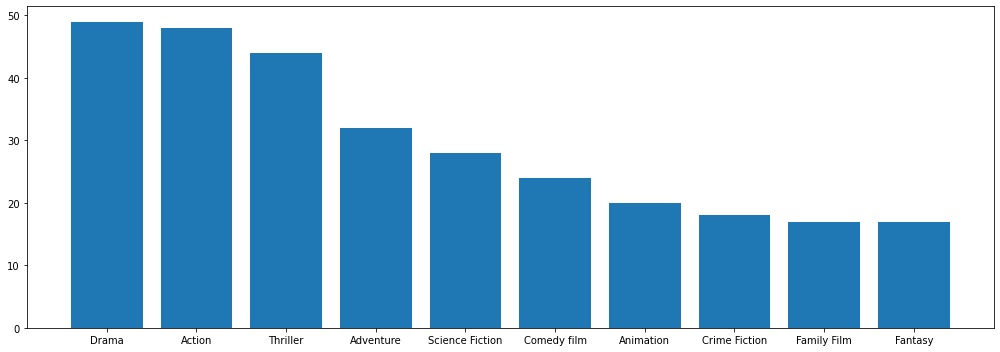

In [157]:
# inspecting the most popular movie genres 
bins = top_genres[:10]
values = nb_appearances[:10]
fig, ax = plt.subplots(figsize = (14,5))
ax.bar(np.arange(len(values)),values)
x = np.arange(len(bins))
ax.set_xticks(x, bins)

plt.tight_layout()
plt.show()

In [158]:
# use the merged data frame ( actors and movies) to then remove rows where the actors sex 
# is not precised, then sum compute for each of the selected movie features 
# the number number of occuerences per sex 
# finally normalize and multiply by 100 to get a percentage for men, women
sex_genre_df = actors_movies_df[~ actors_movies_df['sex'].isna()]
sex_genre_df = pd.DataFrame(sex_genre_df[selected_genres].sum(), columns=['all'])
sex_genre_df['women'] = actors_movies_df[actors_movies_df['sex'] == 'F'][selected_genres].sum() / sex_genre_df['all'] * 100
sex_genre_df['men'] = actors_movies_df[actors_movies_df['sex'] == 'M'][selected_genres].sum() / sex_genre_df['all'] * 100
sex_genre_df = sex_genre_df.round()

/tmp/ipykernel_89094/1045808997.py:6: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  sex_genre_df = pd.DataFrame(sex_genre_df[selected_genres].sum(), columns=['all'])
/tmp/ipykernel_89094/1045808997.py:7: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  sex_genre_df['women'] = actors_movies_df[actors_movies_df['sex'] == 'F'][selected_genres].sum() / sex_genre_df['all'] * 100
/tmp/ipykernel_89094/1045808997.py:8: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  sex_genre_df['men'] = actors_movies_df[actors_movies_df['sex'] == 'M'][selected_genres].sum() / sex_genre_df['all'] * 100


In [159]:
sex_genre_df.sort_values('all')

,all,women,men
Romance Film,33.0,39.0,61.0
Comedy film,82.0,29.0,71.0
Family Film,103.0,33.0,67.0
Crime Fiction,116.0,28.0,72.0
Animation,119.0,26.0,74.0
Fantasy,139.0,32.0,68.0
Science Fiction,175.0,27.0,73.0
Adventure,206.0,28.0,72.0
Thriller,233.0,31.0,69.0
Drama,234.0,31.0,69.0


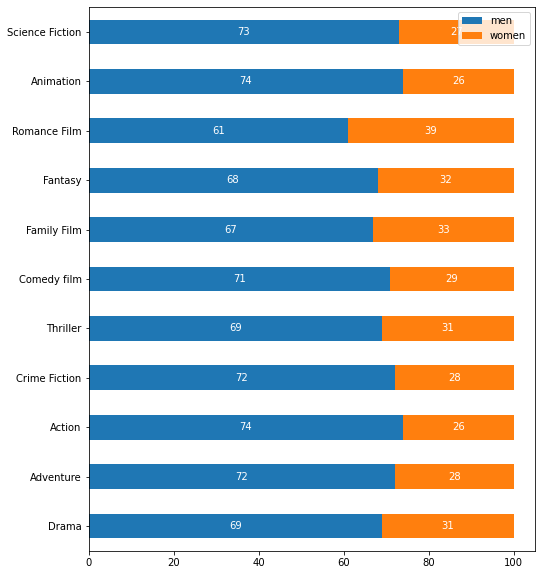

In [160]:
# each whole stacked bar is a 100 units long
# this allows to quickly and easely see the difference in the sex ratio
# between genres
ax = sex_genre_df[['men', 'women']].plot.barh(stacked=True, figsize = (8,10))
for container in ax.containers:
    ax.bar_label(container, label_type='center', color='w')
    
    
# Create a figure instance
fig = plt.figure(1, figsize=(8, 10))

# Create an axes instance
ax = fig.add_subplot(111)

# Create the boxplot
bp = ax.boxplot(np.array([categories[0].values]))
ax.boxplot(np.array(categories[1].values))

# Save the figure
fig.savefig('fig1.png', bbox_inches='tight')


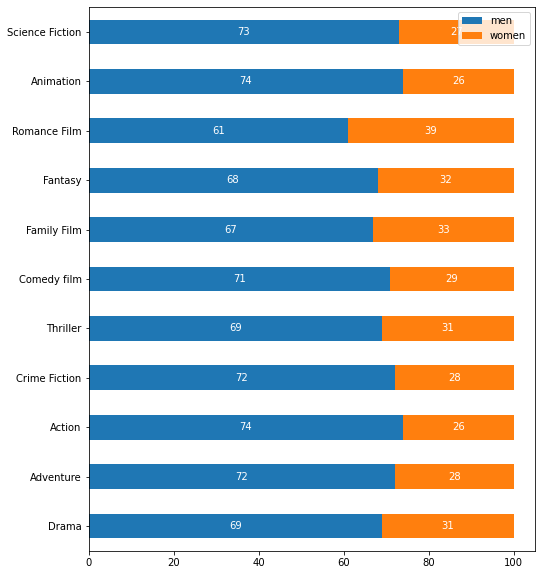

In [162]:
# each whole stacked bar is a 100 units long
# this allows to quickly and easely see the difference in the sex ratio
# between genres
fig = plt.figure(1, figsize=(8, 10))
ax = fig.add_subplot(111)
_ = sex_genre_df[['men', 'women']].plot.barh(stacked=True, figsize = (8,10), ax=ax)
for container in ax.containers:
    ax.bar_label(container, label_type='center', color='w')
    
    
# Create a figure instance


# Create an axes instance

# Save the figure
fig.savefig('data/2013_genres_sexes.png')


In [19]:
# we compute how many roles are played by men and women 
print("Role numbers divided by sex")
roles_by_sex = actors_df.sex.value_counts()
print(f"Male roles: {roles_by_sex.loc['M']}, Female roles: {roles_by_sex.loc['F']}")
print(f"{round( roles_by_sex.loc['F'] / (roles_by_sex.loc['F'] + roles_by_sex.loc['M']) * 100, 2)}% of roles are female")

# then we see how many actors are male and how many female
print("\nActors numbers divided by sex")
actors_by_sex = actors_df.groupby('sex').actor_ID.unique().apply(len)
print(f"Male actors: {actors_by_sex.loc['M']}, Female actors: {actors_by_sex.loc['F']}")
print(f"{round( actors_by_sex.loc['F'] / (actors_by_sex.loc['F'] + actors_by_sex.loc['M']) * 100, 2)}% of actors are female")

Role numbers divided by sex
Male roles: 191524, Female roles: 99245
34.13% of roles are female

Actors numbers divided by sex
Male actors: 31768, Female actors: 19188
37.66% of actors are female


In [20]:
# we noticed that some ages at release were negative which is impossible 
# since if you are not born you cannot be in a movie
actors_age_df = actors_df[ ~actors_df['age_at_release'].isna()]
actors_age_df = actors_age_df[ actors_age_df['age_at_release'] >= 0]

# we also compute the age of the oldest actor to make sure it's not some crazy big 
# impossible number and use it to specify the number of bins
max_age = int(actors_age_df.age_at_release.sort_values().max())
print(f"The oldest actor is/was {max_age} years old")

The oldest actor is/was 103 years old


In [21]:
def quartiles(data):
    """
    Method that takes in 1 dimensional data and 
    returns: 1st, second ( median) and 3rd quartile"""
    return [np.quantile(data, x/4) for x in range(1, 4)]

Women        -- 1st quartile 24.0, median 30.0, 3rd quartile 40.0 | IQR: 16.0
Men          -- 1st quartile 31.0, median 39.0, 3rd quartile 49.0 | IQR: 18.0
All Actors   -- 1st quartile 28.0, median 36.0, 3rd quartile 47.0 | IQR: 19.0


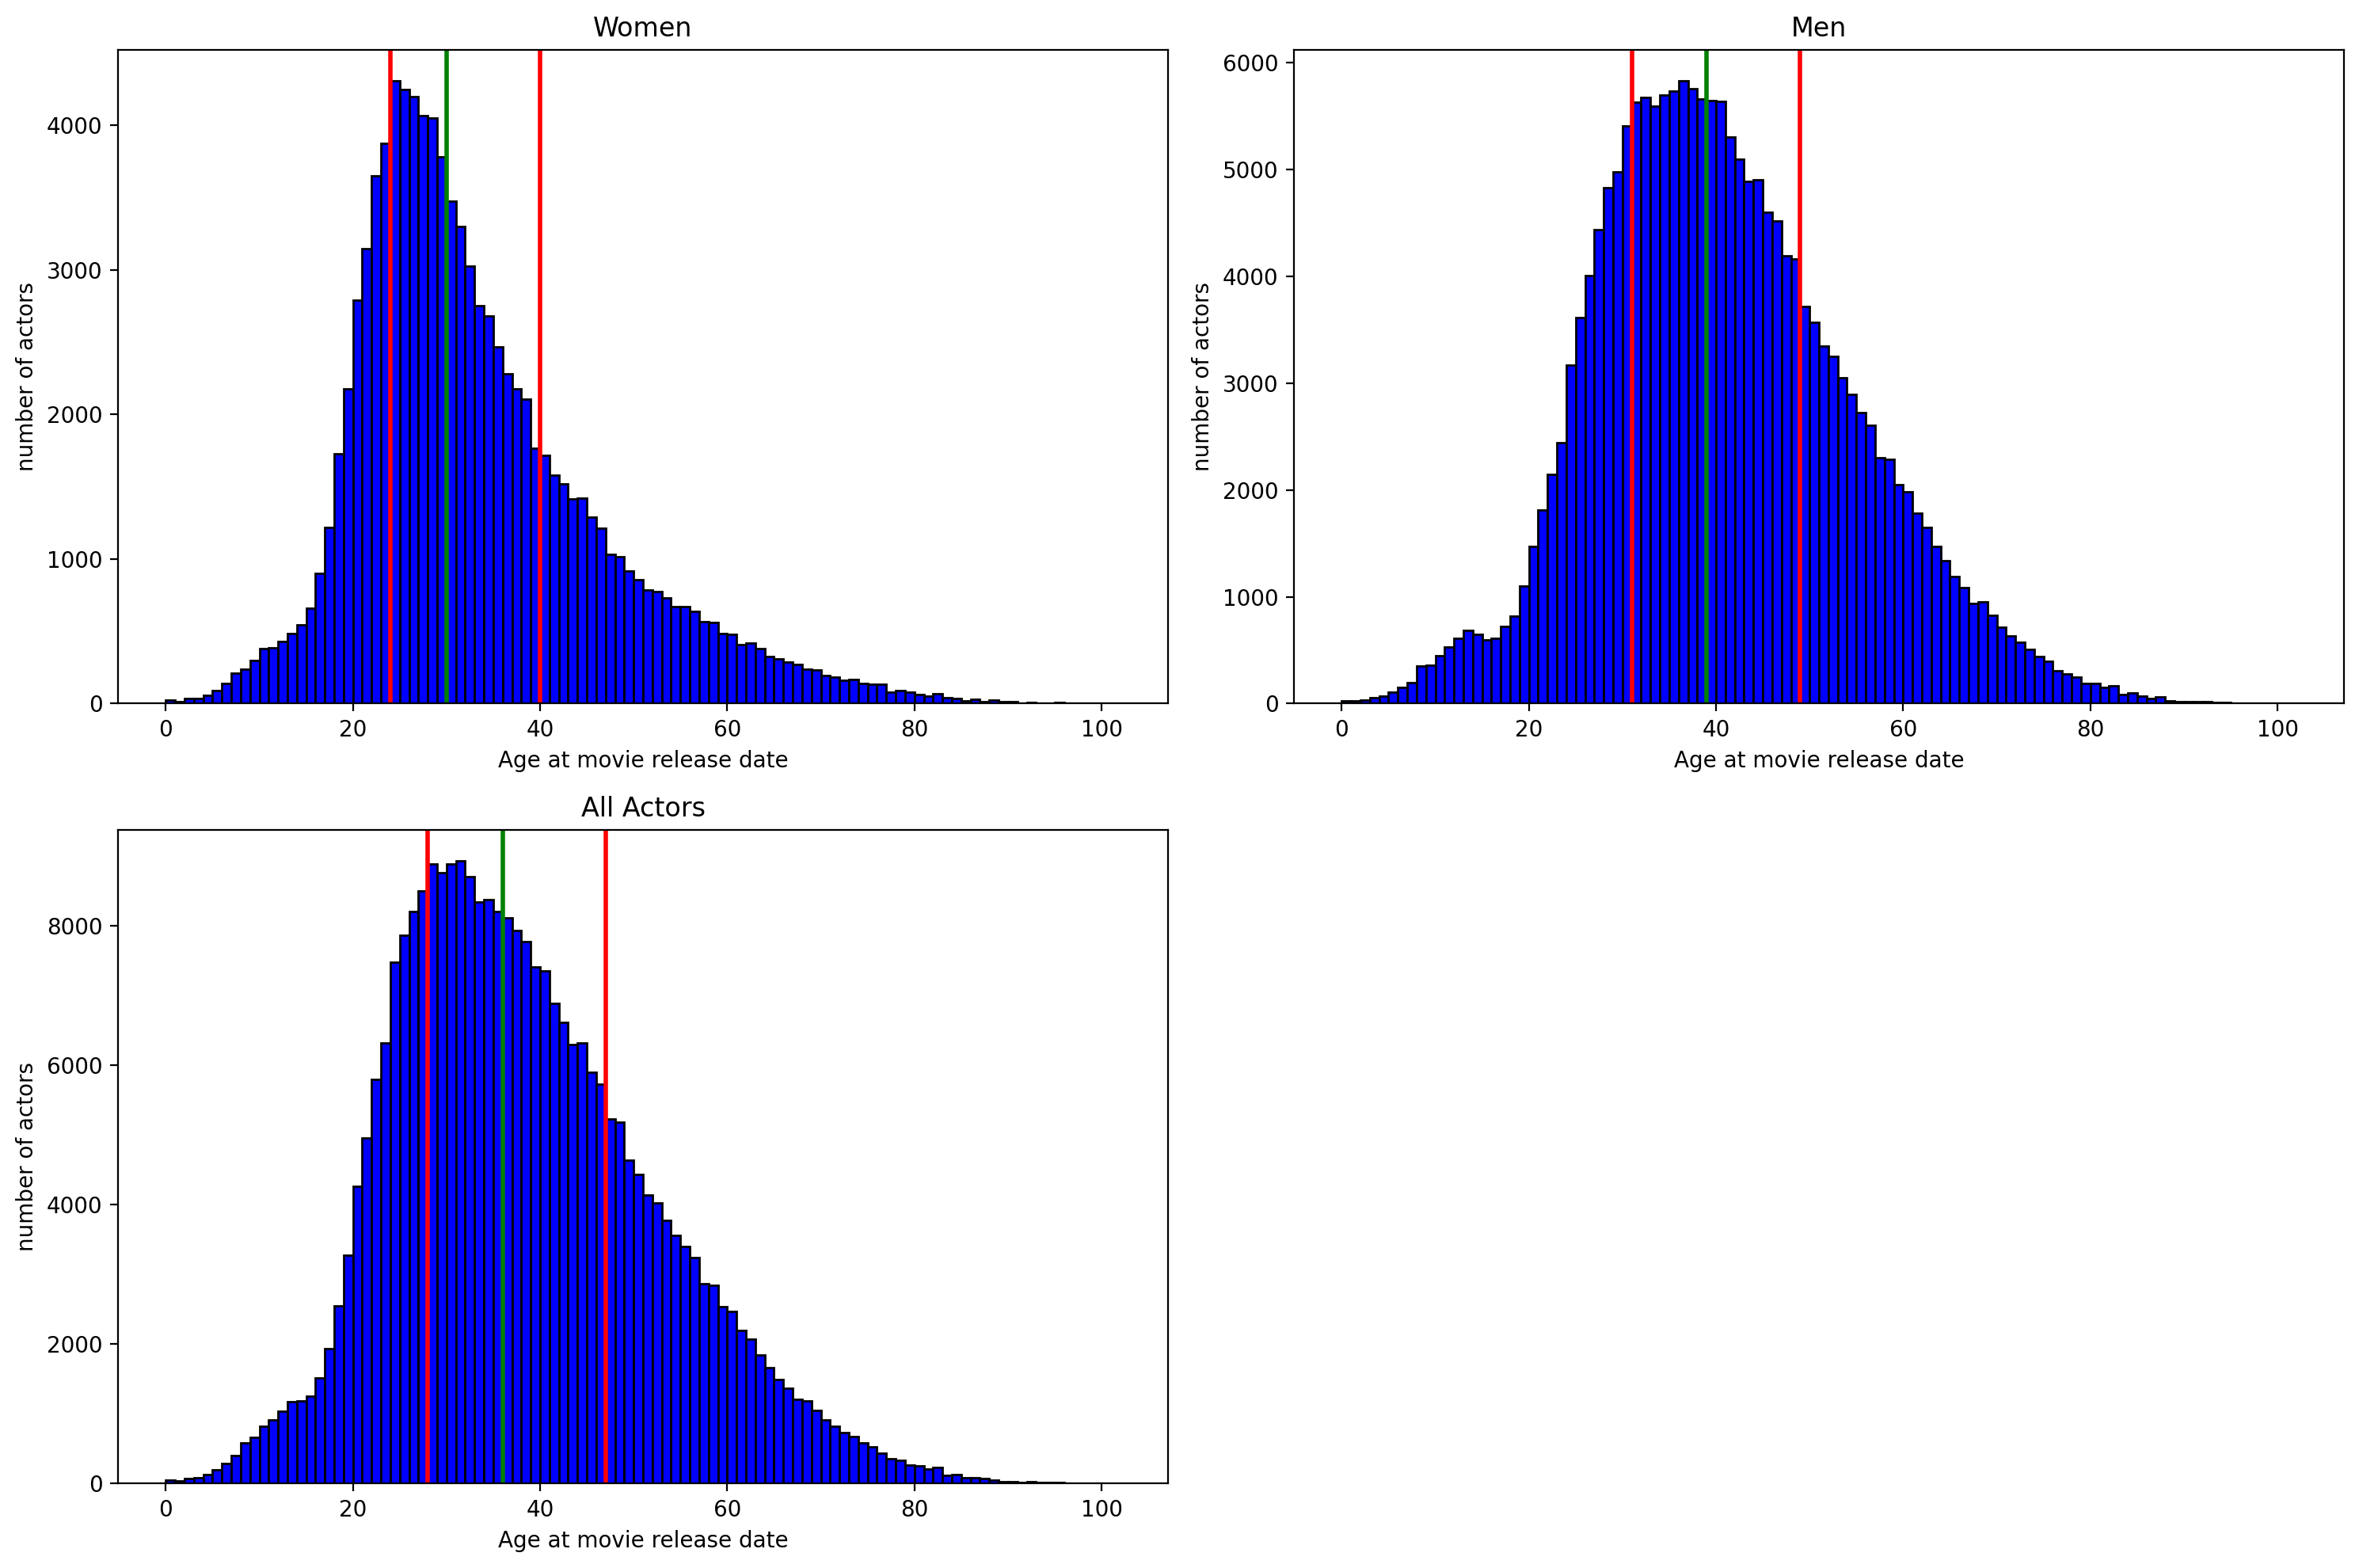

In [22]:
# we then plot the age of the men, women and all the actors at release date of the movie
# We also plot the 1st and 3rd quartile in RED
# and the median in GREEN
# IQR == Interquartile range

categories = [actors_age_df[actors_age_df['sex'] == "F"]['age_at_release'],
              actors_age_df[actors_age_df['sex'] == "M"]['age_at_release'],
              actors_age_df['age_at_release']]

cat_names = [ "Women", "Men", "All Actors"]




figure(figsize=(15, 10), dpi=200)
for i, data in enumerate(categories):
    
    # Set up the plot
    ax = plt.subplot(2, 2, i + 1)
    
    # Draw the plot
    ax.hist(data, [x for x in range(max_age)], color = 'blue', edgecolor = 'black')
    stats = quartiles(data)
    print(f"{cat_names[i]:12} -- 1st quartile {stats[0]}, median {stats[1]}, 3rd quartile {stats[2]} | IQR: {stats[2] - stats[0]}")
    ax.axvline(stats[0], color='r', linewidth=2)
    ax.axvline(stats[1], color='g', linewidth=2)
    ax.axvline(stats[2], color='r', linewidth=2)
    ax.set_xlabel('Age at movie release date')
    ax.set_ylabel("number of actors")
    
#     Title and labels
    ax.set_title(cat_names[i])

plt.tight_layout()
plt.show()

In [23]:
actors_age_df.release_date.astype('datetime64[ns]').dt.year

0         1970
1         1970
2         1970
3         1970
4         1970
          ... 
450659    1970
450660    1970
450661    1970
450664    1970
450665    1970
Name: release_date, Length: 290400, dtype: int64

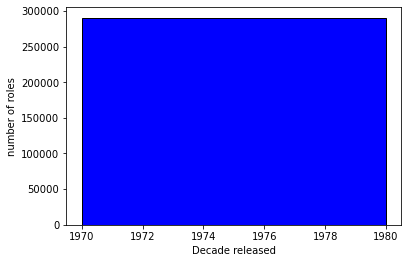

In [24]:
# we also explore the distribution of the roles accross time 
# to know if we have enough data to do sex separation
import datetime
years_apparue = actors_age_df.release_date.astype('datetime64[ns]').dt.year

binwidth = 10
start = int(min(years_apparue/10))*10
end  = (int(max(years_apparue/10))+2)*10
ax = plt.hist(years_apparue, bins=range(start, end , binwidth), color = 'blue', edgecolor = 'black')
plt.xlabel('Decade released')
plt.ylabel("number of roles")
plt.show()


# data bins for each decade from 1900 to 2020

In [25]:
data_bins = [[1900+ 10*x, 1910 + 10*x] for x in range(12)]

# we do the same sex divided plot but for each decade to see the evolution of the age at release distribution

F = Female, M = Male, A = all actors,  IQR = interquartile range, 1st, 2nd, 3rd are the quartiles

                 1st | 2nd | 3rd                 1st | 2nd | 3rd               1st | 2nd | 3rd
[1900, 1910] | 

AttributeError: 'int' object has no attribute 'split'

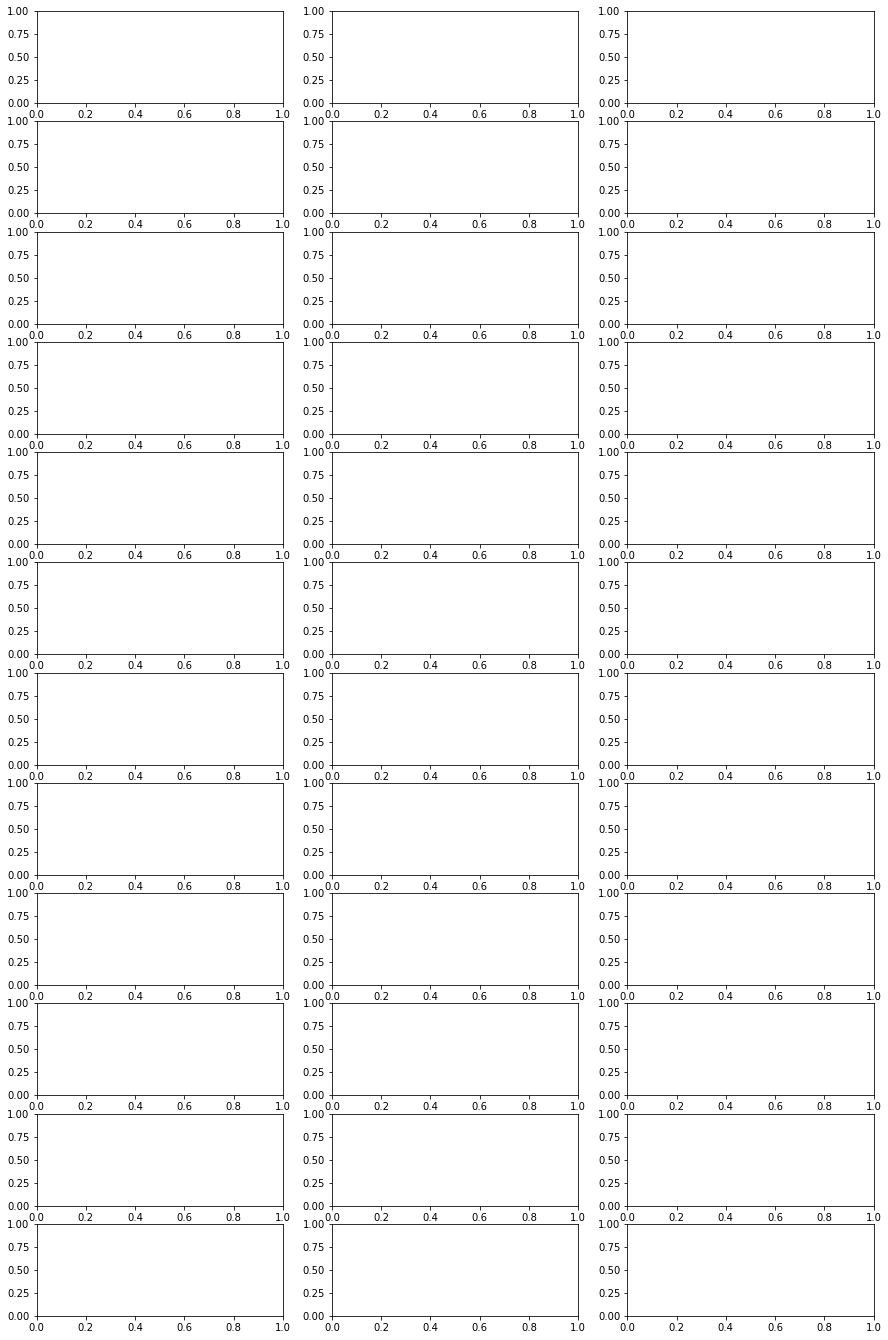

<Figure size 3000x3000 with 0 Axes>

In [26]:




sex_df_dict = {'female': actors_age_df[actors_age_df['sex'] == "F"],
              'male': actors_age_df[actors_age_df['sex'] == "M"],
              'all': actors_age_df}

cat_names = [ "Women", "Men", "All Actors"]


fig, axes = plt.subplots(nrows=12, ncols=3, figsize=(15, 24))

print("F = Female, M = Male, A = all actors,  IQR = interquartile range, 1st, 2nd, 3rd are the quartiles\n")
print("                 1st | 2nd | 3rd                 1st | 2nd | 3rd               1st | 2nd | 3rd")
figure(figsize=(15, 15), dpi=200)
for row, date_range in enumerate(data_bins):
    print(date_range, end=' | ')
    for column, sex in enumerate(sex_df_dict.keys()):
        
        # Draw the plot
        rel_y = np.array([date.split('-')[0] for date in  sex_df_dict[sex]['release_date']])
        data = sex_df_dict[sex][ (rel_y  > str(date_range[0]) ) & (rel_y  < str(date_range[1]) )]['age_at_realease']
        axes[row,column].hist(data, [x for x in range(105)], color = 'blue', edgecolor = 'black')
        data = data.values
        if( data.shape[0] > 10):
            bstats = quartiles(data)
            print( f"{sex[0].upper()}:{str(bstats):18} IQR: {str(int(bstats[2] - bstats[0])):2} | ", end='' )

            axes[row,column].axvline(bstats[0], color='r', linewidth=2)
            axes[row,column].axvline(bstats[1], color='g', linewidth=2)
            axes[row,column].axvline(bstats[2], color='r', linewidth=2)
                
            axes[row,column].set_xlabel('Age at movie release date')
            axes[row,column].set_ylabel("number of actors")


    print()
    
for ax, col in zip(axes[0], sex_df_dict.keys()):
    ax.set_title(col)

for ax, row in zip(axes[:,0], data_bins):
    ax.set_ylabel(row, size='large' )
    
plt.tight_layout()
plt.show()


In [ ]:
# we also inspect the ratio of male female roles over time 
ages = np.zeros((len(data_bins), 3))
for row, date_range in enumerate(data_bins):
    for column, sex in enumerate(sex_df_dict.keys()):
        
        rel_y = np.array([date.split('-')[0] for date in  sex_df_dict[sex]['release_date']])
        data = sex_df_dict[sex][ (rel_y  > str(date_range[0]) ) & (rel_y  < str(date_range[1]) )]['age_at_realease']
        
        ages[row,column] = data.shape[0]

    
for row, date_range in enumerate(data_bins):
    print(date_range, end=' | ')
    print( f"Females roles represent: {round(ages[row,0] / ages[row,2]* 100,2):4.2f}% of roles")

In [ ]:
# finally we started looking at the actors with the most roles and inspecting their sex
actors_df.groupby(['actor_name', 'sex'])['actor_ID' ].count().sort_values(ascending=False).head(15)#.value_counts()

In [ ]:
lgbt_index = np.array([ 'LGBT' in set(row.genres) for idx, row in movies_df.iterrows()])

In [ ]:
lgbt_df = movies_df[lgbt_index]

In [ ]:
lgbt_df.release_date

In [ ]:
lgbt_df = lgbt_df[lgbt_df['release_date'].notna()]


In [ ]:
# [datetime.strptime(date, '%Y-%m-%d').year if len(date) > 4 else int(date) for date in lgbt_df.release_date]
lgbt_years = np.array([ int(date[:4]) for date in lgbt_df.release_date])
unique, counts = np.unique(lgbt_years, return_counts=True)
print(unique.shape)
figure(figsize=(12, 7))
_=plt.bar(unique,counts)

In [ ]:

movies_df = movies_df[movies_df['release_date'].notna()]
years = np.array([ int(date[:4]) for date in movies_df.release_date])
unique, counts = np.unique(years, return_counts=True)
unique.shape

In [ ]:
from datetime import datetime
datetime.strptime(lgbt_df.release_date[201], '%Y-%m-%d').year


## 2016

In [ ]:
movies_2016 = movies_df[movies_df['release_date'].year == 2016] 

In [ ]:
# we then plot the age of the men, women and all the actors at release date of the movie
# We also plot the 1st and 3rd quartile in RED
# and the median in GREEN
# IQR == Interquartile range

categories = [actors_start_2013[actors_start_2013['sex'] == "F"]['age_at_realease'],
              actors_start_2013[actors_start_2013['sex'] == "M"]['age_at_realease'],
              actors_start_2013['age_at_realease']]

cat_names = [ "Women", "Men", "All Actors"]


max_age = int( actors_start_2013.age_at_realease.max() ) 

figure(figsize=(15, 10), dpi=200)
for i, data in enumerate(categories):
    
    # Set up the plot
    ax = plt.subplot(2, 2, i + 1)
    
    # Draw the plot
    ax.hist(data, [x for x in range(max_age)], color = 'blue', edgecolor = 'black')
    stats = quartiles(data)
    print(f"{cat_names[i]:12} -- 1st quartile {stats[0]}, median {stats[1]}, 3rd quartile {stats[2]} | IQR: {stats[2] - stats[0]}")
    ax.axvline(stats[0], color='r', linewidth=2)
    ax.axvline(stats[1], color='g', linewidth=2)
    ax.axvline(stats[2], color='r', linewidth=2)
    ax.set_xlabel('Age at movie release date')
    ax.set_ylabel("number of actors")
    
#     Title and labels
    ax.set_title(cat_names[i])

plt.tight_layout()
plt.show()

In [ ]:
categories[0].values

In [ ]:
# Create a figure instance
fig = plt.figure(1, figsize=(9, 6))

# Create an axes instance
ax = fig.add_subplot(111)

# Create the boxplot
bp = ax.boxplot(np.array([categories[0].values]))
ax.boxplot(np.array(categories[1].values))

# Save the figure
fig.savefig('fig1.png', bbox_inches='tight')

In [ ]:
import seaborn as sns

letter2sex = {"M" : "Man", "F" : "Woman"}
actors_start_2013 = actors_start_2013.replace({"sex": letter2sex})

fig, ax = plt.subplots(figsize=(5,8))
plt.suptitle('')
_=sns.boxplot(x='sex', y='age_at_release', data=actors_start_2013, ax=ax).set_title('Actors age distribution for movies from 2013 to 2016')



lines = ax.get_lines()
categories = ax.get_xticks()

for cat in categories:
    for x in [0,1,4]:
        y = round(lines[x+cat*6].get_ydata()[0],1) 
        ax.text(
            cat, 
            y, 
            f'{y}', 
            ha='center', 
            va='center', 
            fontweight='semibold', 
            size=10,
            color='white',
            bbox=dict(facecolor='#828282', edgecolor='#828282')
        )
        
fig.savefig("data/from_2013_sex_ages.png") 